In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
#import plotly.express as px

In [3]:
path = r'D:\C DUURSEEN\DIPLOM\data beltgel bolon busad'

In [47]:
df = pd.read_excel(path + '\Data-2011.xlsx')
df_names = pd.read_excel(path + '\Data-2011.xlsx', sheet_name = 'name')

df = df.set_index(df['Date']).drop(columns = ['Date']).dropna()

In [48]:
df_names

,variable,names
0,var0,"Нүүрс олборлолт, мянган тонн"
1,var1,Зэсийн баяжмалын үйлдвэрлэл(35%) мянган тонн
2,var2,"Молибдений баяжмалын үйлдвэрлэл, тонн"
3,var3,"Зэсийн баяжмалын экспортын үнэ, ам доллар/тн"
4,var4,"Нийт худалдаа, сая доллар"
...,...,...
125,gdp_nonmining,Уул уурхайн бус салбарын ДНБ
126,var123,Хөнгөн цагааны үнэ
127,var124,Төмрийн хүдэрийн үнэ
128,var125,Цайрын үнэ


In [49]:
def hp_filter(main_df):
    trend_ls = []
    cycle_ls = []
    for i in range(main_df.shape[1]):
        df_slice = main_df.iloc[:,i]
        """
        quarterly data's param = 1600
        monthly data's param = 129600
        annual data's param = 6.25
        
        Gan-Ochir = 1600 (quarterly data)
        Eviews = 14400 (monthly data)
        """
        param = 14400
        cycle, trend = sm.tsa.filters.hpfilter(df_slice, param)
        cycle_ls.append(cycle)
        trend_ls.append(trend)
        
        trend_df = pd.DataFrame(trend_ls).T
        cycle_df = pd.DataFrame(cycle_ls).T
        
    new_col = main_df.columns
        
    trend_df.columns = new_col
    cycle_df.columns = new_col
        
    return trend_df #, cycle_df

In [50]:
def seas_decompose(main_df):
    """
    LOESS method
    """
    from statsmodels.tsa.seasonal import STL
    # from statsmodels.tsa.seasonal import seasonal_decompose

    seasonality_adj_ls = []
    for i in range(main_df.shape[1]):
        df_slice = main_df.iloc[:,i]
        
        df_slice_compose = STL(df_slice, seasonal = 13).fit()
        seasonality_adj = df_slice_compose.resid
        
        # df_slice_compose = seasonal_decompose(df_slice, model='multiplicative', period=12)
        # seasonality_adj = df_slice / df_slice_compose.seasonal
        
        seasonality_adj_ls.append(seasonality_adj)

    df_adj = pd.DataFrame(seasonality_adj_ls).T
    df_adj.columns = main_df.columns

    return df_adj


In [51]:
def avg_center(main_df):
    """
    Central point average method
    """
    avg1_ls = []
    avg2_ls = []

    for i in range(main_df.shape[1]):
        df_value = main_df.iloc[:,i].values
        
        for j in range(len(df_value)):
            if j == len(df_value) - 11:
                break
            else:
                avg1 = df_value[j:j+12].mean()
                avg2 = df_value[j+1:j+13].mean()
    
                avg1_ls.append(avg1)
                avg2_ls.append(avg2)
    
        avg1_ls = avg1_ls[:-1]
        avg2_ls = avg2_ls[:-1]
    
    avg_center = (np.array(avg1_ls) + np.array(avg2_ls)) / 2
    df_center = pd.DataFrame(avg_center.reshape(-1, int(len(avg_center) / len(main_df.columns)))).T
    
    df_center.index = main_df.index[6:-6]
    df_center.columns = main_df.columns

    return df_center

In [52]:
def normalize(main_df):
    normalized_ls = []
    for i in range(main_df.shape[1]):
        df_slice = main_df.iloc[:,[i]]
        
        max_val = df_slice.max().values[0]
        min_val = df_slice.min().values[0]
        range_val = max_val - min_val
        
        df_slice_values = df_slice.values
        
        for j in range(len(df_slice_values)):
            old_val = df_slice.iloc[j].values[0]
            
            norm_val = (old_val - min_val) / range_val
            new_val = 2 * norm_val - 1
            
            normalized_ls.append(new_val)
    
    norm_df = pd.DataFrame(np.array(normalized_ls).reshape(-1,len(main_df))).T
    norm_df.columns = main_df.columns
    norm_df.index = main_df.index

    return norm_df

In [53]:
"""
Анхний датагаас hodrick prescott filter ээр трендийг ялган авч
LOESS аргаар улирлын нөлөөг засварлаж
төвт дундажийн аргаар дундчилсан 
Хэмжигдэхүүний ялгаатай байдлыг арилгах зорилгоор -1 ээс 1 -ийн хооронд стандартчилав
"""
df_adj_norm = normalize(avg_center(seas_decompose(hp_filter(df))))


In [54]:
def cross(main_df):
    from scipy import signal
    from scipy.signal import correlate
    
    gdp = main_df['gdp_real'].values
    gdp = (gdp - np.mean(gdp)) / (np.std(gdp) * len(gdp))
    
    temp1 = pd.DataFrame(main_df.columns)
    temp2 = temp1[~temp1[0].isin(['gdp_real'])].values
    temp2 = np.concatenate(temp2)

    other = main_df.loc[:,temp2]
    
    lags_col = list(other.columns + '_lags')
    corr_col = list(other.columns + '_corr')    

    col_ls = []
    lags_ls = []
    for i in range(other.shape[1]):
        check = other.iloc[:,i].values
        check = (check - np.mean(check)) / (np.std(check))
        
        result = np.correlate(check, gdp, 'full')
        lags = signal.correlation_lags(len(check), len(gdp))
        
        lags_ls.append(lags)
        lags_ls.append(result)

        lags_tmp = lags_col[i]
        corr_tmp = corr_col[i]
        col_ls.append(lags_tmp)
        col_ls.append(corr_tmp)
    
    df_cross = pd.DataFrame(lags_ls).T
    
    """
    Хувьсагч болгоны хамгийн max correlation - ны утгыг гаргаж авах
    """
    max_ls = []
    for i, j in zip(range(0,df_cross.shape[1],2), range(1,df_cross.shape[1],2)):
        temp = df_cross.iloc[:,[i,j]]
        max_val = temp.iloc[temp[j].idxmax()].values
        max_ls.append(max_val)

    max_df = pd.DataFrame(max_ls, columns = ['lags', 'ccf'])
    max_col = pd.DataFrame(other.columns, columns = ['var_names'])
    max_df = pd.concat([max_df, max_col], axis = 1)

    """
    lags болон correlation - ны харгалзах босго утгаар шүүж авах
    """
    temp_col = pd.DataFrame(col_ls)
    temp_col = temp_col[0].str.split('_', expand = True)[0].tolist()
    temp1_ser = pd.Series(dtype = 'int')
    temp2_ser = pd.Series(dtype = 'int')
    temp3_ser = pd.Series(dtype = 'object')
    
    threshold = 0.6
    for i, j in zip(range(0,df_cross.shape[1],2), range(1,df_cross.shape[1],2)):
        df_slice = df_cross.iloc[:,[i,j]]
        df_slice = df_slice[(df_slice[i] < 0) & (df_slice[j] > threshold)].reset_index(drop = True)
        df_slice['var'] = temp_col[i]
        
        temp1_ser = pd.concat([temp1_ser, df_slice.iloc[:,0]], axis = 0)
        temp2_ser = pd.concat([temp2_ser, df_slice.iloc[:,1]], axis = 0)
        temp3_ser = pd.concat([temp3_ser, df_slice.iloc[:,2]], axis = 0)
        
    val_df = pd.concat([temp1_ser, temp2_ser, temp3_ser], axis = 1)
    val_df = val_df.rename(columns = {0:'lags', 1:'corr', 2:'variable'})
    val_df = val_df.sort_values(by = ['lags']).reset_index(drop = True)
    val_df = val_df[val_df['lags'] >= -12].reset_index(drop = True)
    
    df_cross.columns = col_ls        
    
    return df_cross, val_df, max_df

df_cross = cross(df_adj_norm)[0]
val_df = cross(df_adj_norm)[1]
max_df = cross(df_adj_norm)[2]

In [55]:
def index_build(norm_df, val_df):
    """
    PCA ашиглан index байгуулах
    """
    from sklearn.decomposition import PCA

    lags = val_df['lags'].unique()
    
    weight_ls = []
    col_name_ls = []

    df_index = pd.DataFrame()
    for i in lags:
        val_slice = val_df[val_df['lags'] == i]['variable'].tolist()
        val_slice_pca = norm_df.loc[:, val_slice]
        col_name_ls.append(val_slice)

        pca = PCA(n_components = len(val_slice_pca.columns))
        pca.fit(val_slice_pca)

        eigen = pca.explained_variance_
        summa = np.sum(eigen)
        weight = eigen / summa
        weight_ls.append(weight)

        index_cal = (val_slice_pca * weight).sum(axis = 1)

        index = pd.DataFrame(index_cal, columns = [f'{i} lag'])
        df_index = pd.concat([df_index, index], axis = 1)

    df_index['gdp_real'] = norm_df['gdp_real']
    
    df_weight = pd.DataFrame(weight_ls).T
    df_weight.columns = df_index.columns[:-1] + ' weight'

    df_colnames = pd.DataFrame(col_name_ls).T
    df_colnames.columns = df_index.columns[:-1] + ' variables'

    return df_index, df_weight, df_colnames
df_index = index_build(df_adj_norm, val_df)[0]
df_weight = index_build(df_adj_norm, val_df)[1]
df_colnames = index_build(df_adj_norm, val_df)[2]


In [56]:
def index_build_mean(norm_df, val_df):

    """
    Тэнцүү жинтэйгээр индекс байгуулах.
    """
    lags = val_df['lags'].unique()
    index_ls = []
    lags_name_ls = []
    
    for i in lags:
        val_slice = val_df[val_df['lags'] == i]['variable'].tolist()
        val_slice_index = df_adj_norm.loc[:, val_slice]
        index = val_slice_index.mean(axis =1)
        index_ls.append(index)

        lags_name = str(i) + ' lag equal'
        lags_name_ls.append(lags_name)

    index_df = pd.DataFrame(index_ls).T
    index_df.columns = lags_name_ls
    index_df['gdp_real'] = df_adj_norm['gdp_real']

    return index_df

df_index_mean = index_build_mean(df_adj_norm, val_df)

In [57]:
rsquared_ls = []
for i in range(df_index.shape[1] - 1):
    model = sm.OLS(df.iloc[:,-1].values, df.iloc[:,i].values)
    model_fit = model.fit()
    rsquared = model_fit.rsquared
    rsquared_ls.append(rsquared)

all_model_r = pd.DataFrame(rsquared_ls, index = df_index.columns[:-1]).sort_values(by = [0], ascending = False)

In [58]:
df_cross

,var0_lags,var0_corr,var1_lags,var1_corr,var2_lags,var2_corr,var3_lags,var3_corr,var4_lags,var4_corr,...,var118_lags,var118_corr,var119_lags,var119_corr,var120_lags,var120_corr,var121_lags,var121_corr,var122_lags,var122_corr
0,-141.0,-0.001575,-141.0,0.001160,-141.0,0.000487,-141.0,-0.000294,-141.0,-0.002851,...,-141.0,-0.002786,-141.0,-0.002256,-141.0,-0.001328,-141.0,0.000468,-141.0,-0.002294
1,-140.0,-0.004224,-140.0,0.003506,-140.0,0.001334,-140.0,-0.000866,-140.0,-0.008049,...,-140.0,-0.008004,-140.0,-0.006937,-140.0,-0.004315,-140.0,0.001637,-140.0,-0.006328
2,-139.0,-0.007838,-139.0,0.007183,-139.0,0.002554,-139.0,-0.001660,-139.0,-0.015564,...,-139.0,-0.015689,-139.0,-0.014260,-139.0,-0.009226,-139.0,0.003659,-139.0,-0.012027
3,-138.0,-0.012281,-138.0,0.012273,-138.0,0.004171,-138.0,-0.002561,-138.0,-0.025231,...,-138.0,-0.025724,-138.0,-0.024227,-138.0,-0.016172,-138.0,0.006607,-138.0,-0.019250
4,-137.0,-0.017396,-137.0,0.018799,-137.0,0.006213,-137.0,-0.003412,-137.0,-0.036788,...,-137.0,-0.037870,-137.0,-0.036670,-137.0,-0.025145,-137.0,0.010487,-137.0,-0.027813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,137.0,-0.004638,137.0,-0.003085,137.0,0.006902,137.0,-0.005308,137.0,0.006316,...,137.0,0.000517,137.0,-0.007191,137.0,-0.000052,137.0,0.000023,137.0,-0.006708
279,138.0,-0.002635,138.0,-0.002007,138.0,0.004444,138.0,-0.003502,138.0,0.004574,...,138.0,0.000615,138.0,-0.004693,138.0,-0.000045,138.0,0.000004,138.0,-0.004122
280,139.0,-0.001250,139.0,-0.001169,139.0,0.002512,139.0,-0.002043,139.0,0.002981,...,139.0,0.000569,139.0,-0.002693,139.0,-0.000028,139.0,0.000015,139.0,-0.002159
281,140.0,-0.000425,140.0,-0.000566,140.0,0.001146,140.0,-0.000971,140.0,0.001629,...,140.0,0.000411,140.0,-0.001247,140.0,-0.000009,140.0,0.000025,140.0,-0.000856


In [59]:
from sklearn.metrics import mean_squared_error

In [61]:
choosen_index = '-12.0 lag'
index_names = df_names[df_names['variable'].isin(df_colnames[choosen_index + ' variables'].values)].reset_index(drop = True)
index_comp = index_names['variable'].values

split = int(len(df_index) * 0.9)

"""
PCA - ээр гарган авсан индексийн хувьсагчуудийг тухайн индекс болон gdp_real ээс хамааруулж үзэх
"""
x_data = avg_center(seas_decompose(hp_filter(df))).iloc[:,:-1]
y_data = pd.concat([df_index[['-12.0 lag']], df_index_mean[['-12.0 lag equal']]], axis = 1)

x_data_train = x_data[:split]
x_data_test = x_data[split:]

y_data_train = y_data[:split]
y_data_test = y_data[split:]

months = [3,6,9,12]
pred_x_data_3m = x_data_test[:-(x_data_test.shape[0]-months[0])]
pred_x_data_6m = x_data_test[:-(x_data_test.shape[0]-months[1])]
pred_x_data_9m = x_data_test[:-(x_data_test.shape[0]-months[2])]
pred_x_data_12m = x_data_test[:-(x_data_test.shape[0]-months[3])]

pred_y_data_3m = y_data_test[:-(y_data_test.shape[0]-months[0])]
pred_y_data_6m = y_data_test[:-(y_data_test.shape[0]-months[1])]
pred_y_data_9m = y_data_test[:-(y_data_test.shape[0]-months[2])]
pred_y_data_12m = y_data_test[:-(y_data_test.shape[0]-months[3])]

In [64]:
pip install xgboost

     ---------------------------------------- 99.8/99.8 MB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


[0]	validation_0-rmse:0.68365	validation_1-rmse:0.98354
[87]	validation_0-rmse:0.01197	validation_1-rmse:0.16695
[0]	validation_0-rmse:0.53806	validation_1-rmse:0.64159
[100]	validation_0-rmse:0.00569	validation_1-rmse:0.15081
[126]	validation_0-rmse:0.00206	validation_1-rmse:0.15093


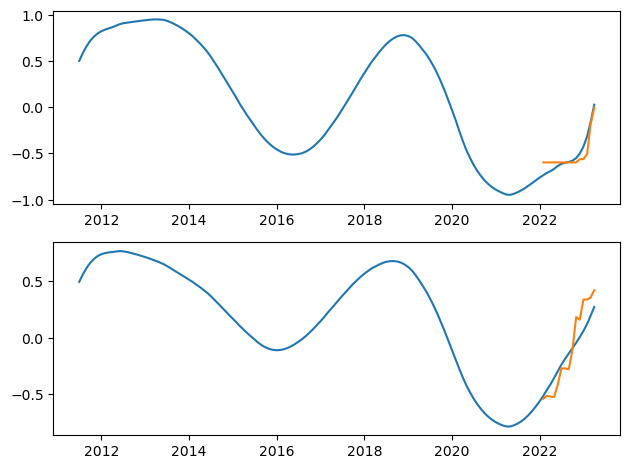

In [66]:
"""
XGBoost
"""
import xgboost as xgb
pred_xgb_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

months_index = ['3 months', '6 months', '9 months', '12 months',]

for i in range(y_data.shape[1]):
    """
    XGBoost model estimation for index and index_comp
    """
    model_xgb = xgb.XGBRegressor(base_score = 0.5, booster='gbtree',    
                           n_estimators = 1000,
                           early_stopping_rounds = 50,
                           objective = 'reg:squarederror',
                           learning_rate = 0.05)
    
    model_xgb_fit = model_xgb.fit(x_data_train, y_data_train.iloc[:,i],
              eval_set = [(x_data_train, y_data_train.iloc[:,i]), (x_data_test, y_data_test.iloc[:,i])],
              verbose = 100)

    """
    Хамгийн нөлөөтэй эхний 20 хувьсагчдыг ялгах авах
    """
    featured = pd.DataFrame(data = model_xgb.feature_importances_,
                            index = model_xgb.feature_names_in_,
                            columns = ['importance'])

    """
    Model - оо сургах
    """
    pred_xgb = model_xgb.predict(x_data_test)
    pred_xgb_test_data = pd.DataFrame(pred_xgb, columns = [f'prediction_xgb {y_data.columns[i]}'])
    pred_xgb_test_temp = pd.concat([pred_xgb_test_temp, pred_xgb_test_data], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_xbg_3m = model_xgb.predict(pred_x_data_3m)
    rmse_xbg_3m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_xbg_3m)

    pred_xbg_6m = model_xgb.predict(pred_x_data_6m)
    rmse_xbg_6m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_xbg_6m)

    pred_xbg_9m = model_xgb.predict(pred_x_data_9m)
    rmse_xbg_9m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_xbg_9m)

    pred_xbg_12m = model_xgb.predict(pred_x_data_12m)
    rmse_xbg_12m = pd.Series(np.sqrt(mean_squared_error(pred_xbg_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_xbg_12m)
    

"""
Нэг dataframe болгон нэгтгэх
"""
pred_xgb_test_temp.index = y_data_test.index
pred_xgb_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_xgb_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_xgb = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_xgb_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_xgb = pd.concat([rsme_xgb, rsme])
    
rsme_xgb_df = pd.DataFrame(rsme_xgb.reset_index(drop = True)).T
rsme_xgb_df.columns = y_data.columns
rsme_xgb_df.index = ['XGBoost']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_xgb_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_xgb_months['model'] = 'XGBoost'


figure, (axis1, axis2) = plt.subplots(y_data.shape[1]) 
# axis1.plot(pred_xgb_data[['-3.0 lag', 'prediction_xgb -3.0 lag']]) 
# axis2.plot(pred_xgb_data[['gdp_real', 'prediction_xgb gdp_real']])
axis1.plot(pred_xgb_data[['-12.0 lag', 'prediction_xgb -12.0 lag']]) 
axis2.plot(pred_xgb_data[['-12.0 lag equal', 'prediction_xgb -12.0 lag equal']])
figure.tight_layout()


In [67]:
rsme_xgb_df

,-12.0 lag,-12.0 lag equal
XGBoost,0.086092,0.148586


In [68]:
rmse_xgb_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.116976,0.08919,0.073125,0.077769,XGBoost
-12.0 lag equal,0.070013,0.09835,0.097048,0.140438,XGBoost


In [ ]:
pip install xgboost

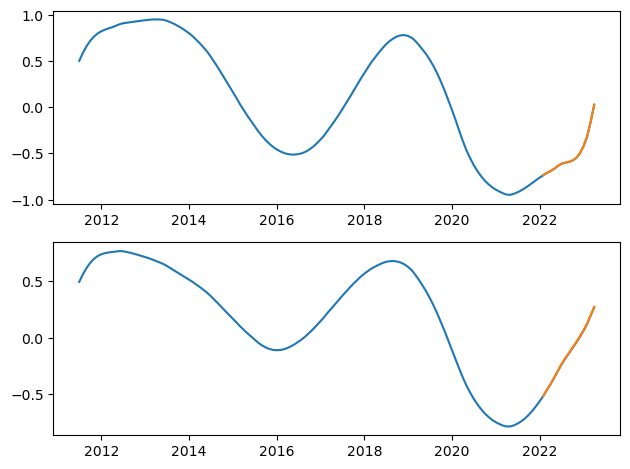

In [70]:
"""
Ridge regression
"""
from sklearn.linear_model import Ridge
pred_ridge_test_temp = pd.DataFrame()
predict_ridge = []

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

choosen_alpha = 0.1
months_index = ['3 months', '6 months', '9 months', '12 months',]
for i in range(y_data.shape[1]):
    """
    Ridge Regression model estimation
    """
    model_ridge = Ridge(alpha = choosen_alpha)
    model_ridge_fit = model_ridge.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_ridge = model_ridge.predict(x_data_test)
    pred_ridge_test_data = pd.DataFrame(pred_ridge, columns = [f'prediction_ridge {y_data.columns[i]}'])
    pred_ridge_test_temp = pd.concat([pred_ridge_test_temp, pred_ridge_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_ridge_3m = model_ridge.predict(pred_x_data_3m)
    rmse_ridge_3m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_ridge_3m)

    pred_ridge_6m = model_ridge.predict(pred_x_data_6m)
    rmse_ridge_6m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_ridge_6m)

    pred_ridge_9m = model_ridge.predict(pred_x_data_9m)
    rmse_ridge_9m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_ridge_9m)

    pred_ridge_12m = model_ridge.predict(pred_x_data_12m)
    rmse_ridge_12m = pd.Series(np.sqrt(mean_squared_error(pred_ridge_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_ridge_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_ridge_test_temp.index = y_data_test.index
pred_ridge_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_ridge_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_ridge = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_ridge_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_ridge = pd.concat([rsme_ridge, rsme])
    
rsme_ridge_df = pd.DataFrame(rsme_ridge.reset_index(drop = True)).T
rsme_ridge_df.columns = y_data.columns
rsme_ridge_df.index = ['Ridge']

rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_ridge_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_ridge_months['model'] = 'Ridge Regression'

figure, (axis1, axis2) = plt.subplots(2) 
# axis1.plot(pred_ridge_data[['-3.0 lag', 'prediction_ridge -3.0 lag']]) 
# axis2.plot(pred_ridge_data[['gdp_real', 'prediction_ridge gdp_real']])
axis1.plot(pred_ridge_data[['-12.0 lag', 'prediction_ridge -12.0 lag']]) 
axis2.plot(pred_ridge_data[['-12.0 lag equal', 'prediction_ridge -12.0 lag equal']])
figure.tight_layout()

In [71]:
rsme_ridge_df

,-12.0 lag,-12.0 lag equal
Ridge,0.000891,0.003207


In [72]:
rmse_ridge_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.000294,0.000583,0.000744,0.000877,Ridge Regression
-12.0 lag equal,0.001202,0.002194,0.002694,0.003183,Ridge Regression


C:\Users\Bolorerdene\anaconda3\anaconda5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.334e-03, tolerance: 5.046e-03
  model = cd_fast.enet_coordinate_descent(


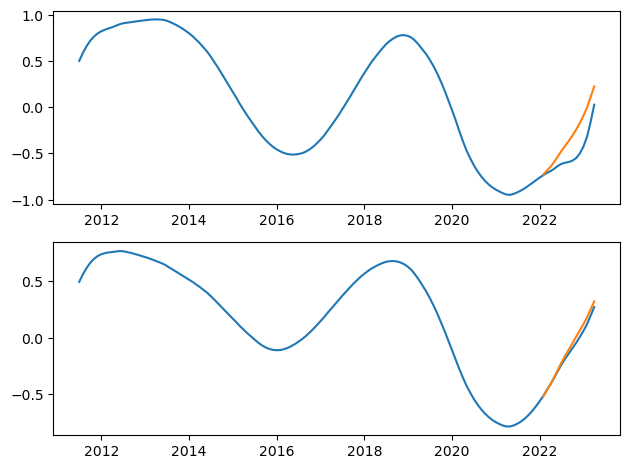

In [73]:
"""
Elastic net
"""
from sklearn.linear_model import ElasticNet
pred_elastic_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

choosen_alpha = 1.0
for i in range(y_data.shape[1]):
    """
    ElasticNet Regression model estimation
    """
    if y_data_train.iloc[:,i].name == '-12.0 lag':
        choosen_alpha = 0.7
    elif y_data_train.iloc[:,i].name == '-12.0 lag equal':
        choosen_alpha = 0.3
    
    
    model_elastic = ElasticNet(alpha = choosen_alpha, l1_ratio = 0.1)
    model_elastic_fit = model_elastic.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_elastic = model_elastic.predict(x_data_test)
    pred_elastic_test_data = pd.DataFrame(pred_elastic, columns = [f'prediction_elastic {y_data.columns[i]}'])
    pred_elastic_test_temp = pd.concat([pred_elastic_test_temp, pred_elastic_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_elastic_3m = model_elastic.predict(pred_x_data_3m)
    rmse_elastic_3m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_elastic_3m)

    pred_elastic_6m = model_elastic.predict(pred_x_data_6m)
    rmse_elastic_6m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_elastic_6m)

    pred_elastic_9m = model_elastic.predict(pred_x_data_9m)
    rmse_elastic_9m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_elastic_9m)

    pred_elastic_12m = model_elastic.predict(pred_x_data_12m)
    rmse_elastic_12m = pd.Series(np.sqrt(mean_squared_error(pred_elastic_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_elastic_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_elastic_test_temp.index = y_data_test.index
pred_elastic_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_elastic_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_elastic = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_elastic_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_elastic = pd.concat([rsme_elastic, rsme])
    
rsme_elastic_df = pd.DataFrame(rsme_elastic.reset_index(drop = True)).T
rsme_elastic_df.columns = y_data.columns
rsme_elastic_df.index = ['Elastic']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_elastic_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_elastic_months['model'] = 'Elastic Net'

figure, (axis1, axis2) = plt.subplots(2) 
# axis1.plot(pred_elastic_data[['-3.0 lag', 'prediction_elastic -3.0 lag']]) 
# axis2.plot(pred_elastic_data[['gdp_real', 'prediction_elastic gdp_real']])
axis1.plot(pred_elastic_data[['-12.0 lag', 'prediction_elastic -12.0 lag']]) 
axis2.plot(pred_elastic_data[['-12.0 lag equal', 'prediction_elastic -12.0 lag equal']])
figure.tight_layout()

In [74]:
rsme_elastic_df

,-12.0 lag,-12.0 lag equal
Elastic,0.220048,0.03914


In [75]:
rmse_elastic_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.030498,0.079543,0.148143,0.206754,Elastic Net
-12.0 lag equal,0.002802,0.008788,0.021656,0.033746,Elastic Net


C:\Users\Bolorerdene\anaconda3\anaconda5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e-02, tolerance: 5.046e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bolorerdene\anaconda3\anaconda5\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.499e-03, tolerance: 2.920e-03
  model = cd_fast.enet_coordinate_descent(


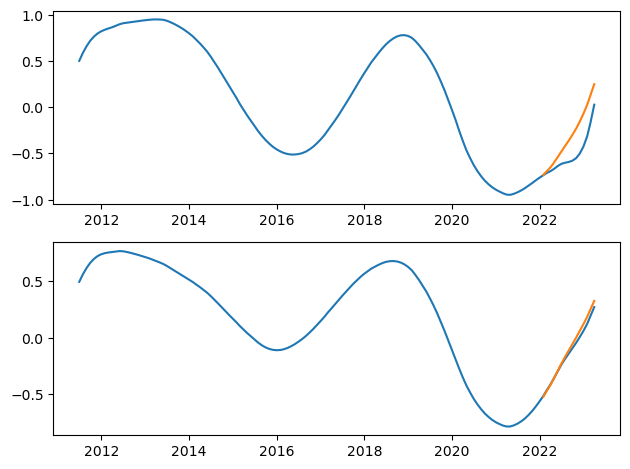

In [77]:
"""
Lasso
"""
from sklearn.linear_model import Lasso
pred_lasso_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []

for i in range(y_data.shape[1]):
    
    """
    Lasso Regression model estimation
    """

    if y_data_train.iloc[:,i].name == '-12.0 lag':
        choosen_alpha = 0.2
    elif y_data_train.iloc[:,i].name == '-12.0 lag equal':
        choosen_alpha = 0.1

    model_lasso = Lasso(alpha = choosen_alpha)
    model_lasso_fit = model_lasso.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_lasso = model_lasso.predict(x_data_test)
    pred_lasso_test_data = pd.DataFrame(pred_lasso, columns = [f'prediction_lasso {y_data.columns[i]}'])
    pred_lasso_test_temp = pd.concat([pred_lasso_test_temp, pred_lasso_test_data], axis = 1)


    """
    Predict in 3, 6, 9, 12 months
    """
    pred_lasso_3m = model_lasso.predict(pred_x_data_3m)
    rmse_lasso_3m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_lasso_3m)

    pred_lasso_6m = model_lasso.predict(pred_x_data_6m)
    rmse_lasso_6m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_lasso_6m)

    pred_lasso_9m = model_lasso.predict(pred_x_data_9m)
    rmse_lasso_9m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_lasso_9m)

    pred_lasso_12m = model_lasso.predict(pred_x_data_12m)
    rmse_lasso_12m = pd.Series(np.sqrt(mean_squared_error(pred_lasso_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_lasso_12m)

"""
Нэг dataframe болгон нэгтгэх
"""
pred_lasso_test_temp.index = y_data_test.index
pred_lasso_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_lasso_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_lasso = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_lasso_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_lasso = pd.concat([rsme_lasso, rsme])
    
rsme_lasso_df = pd.DataFrame(rsme_lasso.reset_index(drop = True)).T
rsme_lasso_df.columns = y_data.columns
rsme_lasso_df.index = ['LASSO']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_lasso_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_lasso_months['model'] = 'LASSO Regression'

figure, (axis1, axis2) = plt.subplots(2) 
# axis1.plot(pred_lasso_data[['-3.0 lag', 'prediction_lasso -3.0 lag']]) 
# axis2.plot(pred_lasso_data[['gdp_real', 'prediction_lasso gdp_real']])
axis1.plot(pred_lasso_data[['-12.0 lag', 'prediction_lasso -12.0 lag']]) 
axis2.plot(pred_lasso_data[['-12.0 lag equal', 'prediction_lasso -12.0 lag equal']])
figure.tight_layout()

In [78]:
rsme_lasso_df

,-12.0 lag,-12.0 lag equal
LASSO,0.231642,0.038007


In [79]:
rmse_lasso_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.026432,0.076401,0.149223,0.214160,LASSO Regression
-12.0 lag equal,0.007205,0.006562,0.017183,0.030595,LASSO Regression


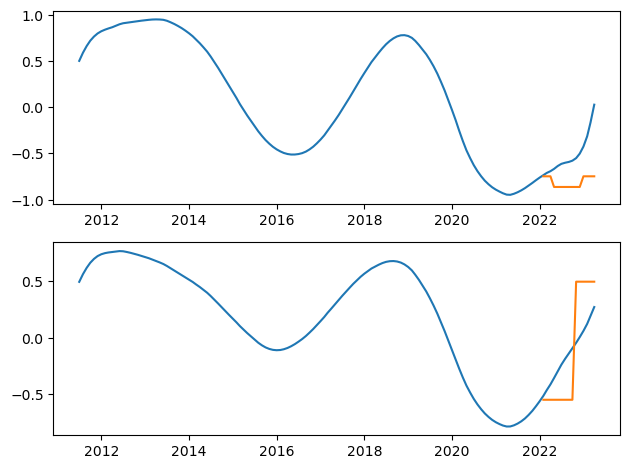

In [81]:
"""
Decision tree
"""
from sklearn.tree import DecisionTreeRegressor
pred_dt_test_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []
for i in range(y_data.shape[1]):
    
    """
    Decision Tree Regressor model estimation
    """
    model_dt = DecisionTreeRegressor(criterion = "squared_error",
                                    max_depth = 100,
                                    min_samples_split = 10,
                                    random_state = 5)
    model_dt_fit = model_dt.fit(x_data_train, y_data_train.iloc[:,i])
    
    """
    Model - оо сургах
    """
    pred_dt = model_dt.predict(x_data_test)
    pred_dt_test_data = pd.DataFrame(pred_dt, columns = [f'prediction_dt {y_data.columns[i]}'])
    pred_dt_test_temp = pd.concat([pred_dt_test_temp, pred_dt_test_data], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_dt_3m = model_dt.predict(pred_x_data_3m)
    rmse_dt_3m = pd.Series(np.sqrt(mean_squared_error(pred_dt_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_dt_3m)

    pred_dt_6m = model_dt.predict(pred_x_data_6m)
    rmse_dt_6m = pd.Series(np.sqrt(mean_squared_error(pred_dt_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_dt_6m)

    pred_dt_9m = model_dt.predict(pred_x_data_9m)
    rmse_dt_9m = pd.Series(np.sqrt(mean_squared_error(pred_dt_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_dt_9m)

    pred_dt_12m = model_dt.predict(pred_x_data_12m)
    rmse_dt_12m = pd.Series(np.sqrt(mean_squared_error(pred_dt_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_dt_12m)


"""
Нэг dataframe болгон нэгтгэх
"""
pred_dt_test_temp.index = y_data_test.index
pred_dt_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_dt_test_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

"""
RSME буюу алдааг нь хэижих
"""
rsme_dt = pd.Series(dtype = 'int')
for i in range(y_data.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_dt_test_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_dt = pd.concat([rsme_dt, rsme])
    
rsme_dt_df = pd.DataFrame(rsme_dt.reset_index(drop = True)).T
rsme_dt_df.columns = y_data.columns
rsme_dt_df.index = ['Decision Tree']


rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_dt_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_dt_months['model'] = 'Decision Tree'

figure, (axis1, axis2) = plt.subplots(2) 
# axis1.plot(pred_dt_data[['-3.0 lag', 'prediction_dt -3.0 lag']]) 
# axis2.plot(pred_dt_data[['gdp_real', 'prediction_dt gdp_real']])
axis1.plot(pred_dt_data[['-12.0 lag', 'prediction_dt -12.0 lag']]) 
axis2.plot(pred_dt_data[['-12.0 lag equal', 'prediction_dt -12.0 lag equal']])
figure.tight_layout()

In [84]:
rsme_dt_df

,-12.0 lag,-12.0 lag equal
Decision Tree,0.350748,0.339407


In [85]:
rmse_dt_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.039083,0.162013,0.205835,0.243863,Decision Tree
-12.0 lag equal,0.094451,0.192932,0.284477,0.347306,Decision Tree


In [88]:
"""
ARIMA
"""
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
adf_ls = []
diff_order_ls = []

for i in range(y_data.shape[1]):
    adf = adfuller(y_data_train.iloc[:,i])[1]
    if adf <= 0.05:
        print(f'{y_data_train.iloc[:,i].name} is stationary')
    elif adf > 0.05:
        print(f'{y_data_train.iloc[:,i].name} is non-stationary')
    adf_ls.append(adf)
    # model_arima_auto = auto_arima(y_data_train.iloc[:,i])
    # model_order = model_arima_auto.order

adf_df = pd.DataFrame(adf_ls, index = y_data.columns, columns = ['ADF test'])

-12.0 lag is non-stationary
-12.0 lag equal is non-stationary


In [89]:
adf_df

,ADF test
-12.0 lag,0.298279
-12.0 lag equal,0.147683


In [90]:
# y3 = y_data_train.iloc[:,0]
# y6 = y_data_train.iloc[:,1]
# y_gdp = y_data_train.iloc[:,2]
# y3_equal = y_data_train.iloc[:,3]

y6 = y_data_train.iloc[:,0]
y3_equal = y_data_train.iloc[:,1]

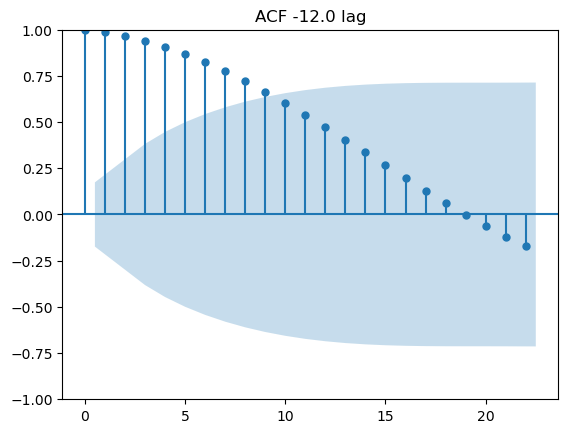

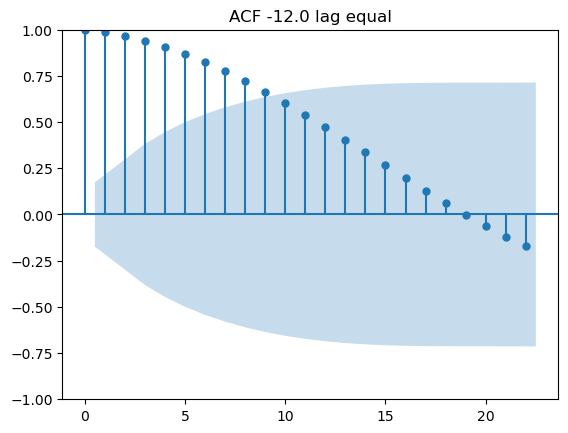

In [92]:
# plot_acf_y3 = plot_acf(y3, title = 'ACF -3.0 lag')
plot_acf_y6 = plot_acf(y6, title = 'ACF -12.0 lag')
# plot_acf_y_gdp = plot_acf(y6, title = 'ACF GDP Real')
plot_acf_y3_equal = plot_acf(y6, title = 'ACF -12.0 lag equal')

C:\Users\Bolorerdene\anaconda3\anaconda5\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


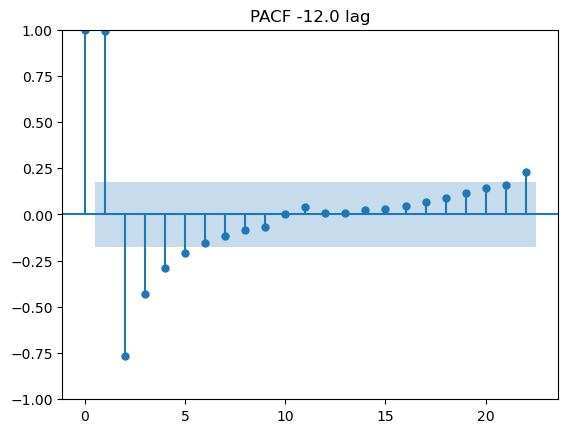

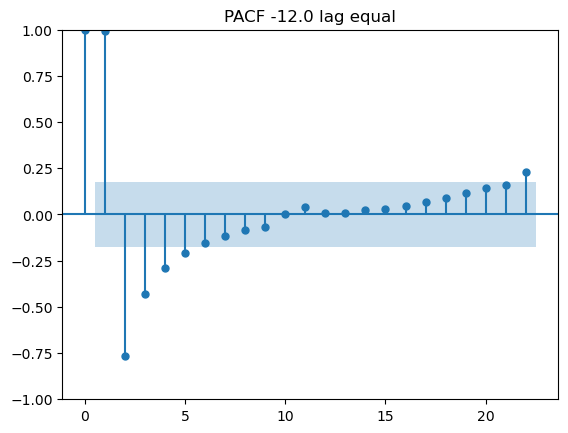

In [93]:
# plot_pacf_y3 = plot_pacf(y3, title = 'PACF -3.0 lag')
plot_pacf_y6 = plot_pacf(y6, title = 'PACF -12.0 lag')
# plot_pacf_y_gdp = plot_pacf(y6, title = 'PACF GDP Real')
plot_pacf_y3_equal = plot_pacf(y6, title = 'PACF -12.0 lag equal')

In [94]:
pred_arima_temp = pd.DataFrame()

pred_3m_rsme = []
pred_6m_rsme = []
pred_9m_rsme = []
pred_12m_rsme = []
for i in range(y_data_train.shape[1]):
    # if y_data_train.iloc[:,i].name == '-12.0 lag':
    #     ar = 3
    #     diff_order = 0
    #     ma = 1
    if y_data_train.iloc[:,i].name == '-12.0 lag':
        ar = 1
        diff_order = 1
        ma = 4
    # elif y_data_train.iloc[:,i].name == 'gdp_real':
    #     ar = 5
    #     diff_order = 0
    #     ma = 5
    elif y_data_train.iloc[:,i].name == '-12.0 lag equal':
        ar = 2
        diff_order = 2
        ma = 2
        
    model_arima = ARIMA(y_data_train.iloc[:,i].values, order = (ar, diff_order, ma))
    model_arima_fit = model_arima.fit()

    pred_arima = model_arima_fit.forecast(len(y_data_test))
    pred_arima_df = pd.DataFrame(pred_arima, index = y_data_test.index, columns = [f'prediction arima y_data_test.columns[i]'])
    pred_arima_temp = pd.concat([pred_arima_temp, pred_arima_df], axis = 1)

    """
    Predict in 3, 6, 9, 12 months
    """
    pred_arima_3m = model_arima_fit.forecast(len(pred_x_data_3m))
    rmse_arima_3m = pd.Series(np.sqrt(mean_squared_error(pred_arima_3m, pred_y_data_3m.iloc[:,i])))
    pred_3m_rsme.append(rmse_arima_3m)

    pred_arima_6m = model_arima_fit.forecast(len(pred_x_data_6m))
    rmse_arima_6m = pd.Series(np.sqrt(mean_squared_error(pred_arima_6m, pred_y_data_6m.iloc[:,i])))
    pred_6m_rsme.append(rmse_arima_6m)

    pred_arima_9m = model_arima_fit.forecast(len(pred_x_data_9m))
    rmse_arima_9m = pd.Series(np.sqrt(mean_squared_error(pred_arima_9m, pred_y_data_9m.iloc[:,i])))
    pred_9m_rsme.append(rmse_arima_9m)

    pred_arima_12m = model_arima_fit.forecast(len(pred_x_data_12m))
    rmse_arima_12m = pd.Series(np.sqrt(mean_squared_error(pred_arima_12m, pred_y_data_12m.iloc[:,i])))
    pred_12m_rsme.append(rmse_arima_12m)

C:\Users\Bolorerdene\anaconda3\anaconda5\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [95]:
rsme_arima = pd.Series(dtype = 'int')
for i in range(y_data_train.shape[1]):
    rsme = pd.Series(np.sqrt(mean_squared_error(pred_arima_temp.iloc[:,i], y_data_test.iloc[:,i])))
    rsme_arima = pd.concat([rsme_arima, rsme])
    
rsme_arima_df = pd.DataFrame(rsme_arima.reset_index(drop = True)).T
rsme_arima_df.columns = y_data_train.columns
rsme_arima_df.index = ['ARIMA']

rmse_3m = pd.DataFrame(pred_3m_rsme, index = y_data.columns)
rmse_3m.columns = ['3 months']

rmse_6m = pd.DataFrame(pred_6m_rsme, index = y_data.columns)
rmse_6m.columns = ['6 months']

rmse_9m = pd.DataFrame(pred_9m_rsme, index = y_data.columns)
rmse_9m.columns = ['9 months']

rmse_12m = pd.DataFrame(pred_12m_rsme, index = y_data.columns)
rmse_12m.columns = ['12 months']

rmse_arima_months = pd.concat([rmse_3m, rmse_6m, rmse_9m, rmse_12m], axis = 1)
rmse_arima_months['model'] = 'ARIMA'

pred_arima_temp.index.name = 'Date'
pred_arima_temp.columns = 'prediction_arima ' + y_data.columns
pred_arima_data = pd.merge(pd.DataFrame(y_data).reset_index(), pred_arima_temp.reset_index(), on = 'Date', how = 'outer').set_index('Date')

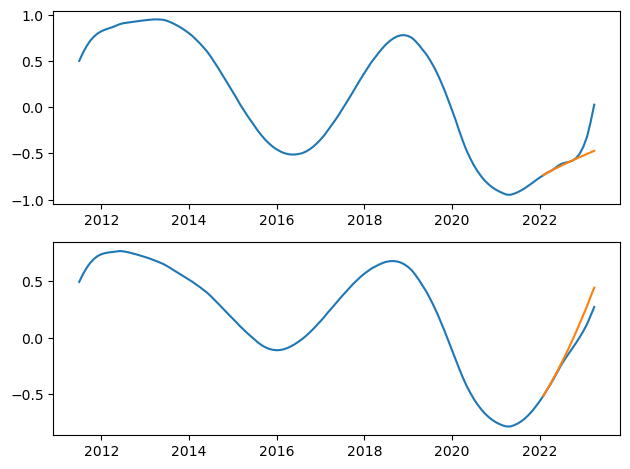

In [96]:
figure, (axis1, axis2) = plt.subplots(2) 
# axis1.plot(pred_arima_data[['-3.0 lag', 'prediction_arima -3.0 lag']]) 
# axis2.plot(pred_arima_data[['gdp_real', 'prediction_arima gdp_real']])
axis1.plot(pred_arima_data[['-12.0 lag', 'prediction_arima -12.0 lag']]) 
axis2.plot(pred_arima_data[['-12.0 lag equal', 'prediction_arima -12.0 lag equal']])
figure.tight_layout()


In [99]:
rsme_arima_df

,-12.0 lag,-12.0 lag equal
ARIMA,0.16395,0.095217


In [100]:
rmse_arima_months

,3 months,6 months,9 months,12 months,model
-12.0 lag,0.00115,0.010211,0.009334,0.031200,ARIMA
-12.0 lag equal,0.00334,0.007078,0.030782,0.066453,ARIMA


In [101]:
"""
Model selection
Нийт test data дээрх харьцуулсан алдааг үнэлэх
"""

'\nModel selection\nНийт test data дээрх харьцуулсан алдааг үнэлэх\n'

In [102]:
rsme = pd.concat([rsme_xgb_df, rsme_ridge_df, rsme_elastic_df, rsme_lasso_df, rsme_dt_df, rsme_arima_df]) #.sort_values(by = ['-3.0 lag'])
rsme

,-12.0 lag,-12.0 lag equal
XGBoost,0.086092,0.148586
Ridge,0.000891,0.003207
Elastic,0.220048,0.039140
LASSO,0.231642,0.038007
Decision Tree,0.350748,0.339407
ARIMA,0.163950,0.095217


In [103]:
rsme_months = pd.concat([rmse_xgb_months, rmse_ridge_months, rmse_elastic_months, rmse_lasso_months, rmse_dt_months, rmse_arima_months], axis = 0)
rsme_months = rsme_months.reset_index(names = 'y_variable')
rsme_months

,y_variable,3 months,6 months,9 months,12 months,model
0,-12.0 lag,0.116976,0.089190,0.073125,0.077769,XGBoost
1,-12.0 lag equal,0.070013,0.098350,0.097048,0.140438,XGBoost
2,-12.0 lag,0.000294,0.000583,0.000744,0.000877,Ridge Regression
3,-12.0 lag equal,0.001202,0.002194,0.002694,0.003183,Ridge Regression
4,-12.0 lag,0.030498,0.079543,0.148143,0.206754,Elastic Net
5,-12.0 lag equal,0.002802,0.008788,0.021656,0.033746,Elastic Net
6,-12.0 lag,0.026432,0.076401,0.149223,0.214160,LASSO Regression
7,-12.0 lag equal,0.007205,0.006562,0.017183,0.030595,LASSO Regression
8,-12.0 lag,0.039083,0.162013,0.205835,0.243863,Decision Tree
9,-12.0 lag equal,0.094451,0.192932,0.284477,0.347306,Decision Tree


<Axes: xlabel='Date'>

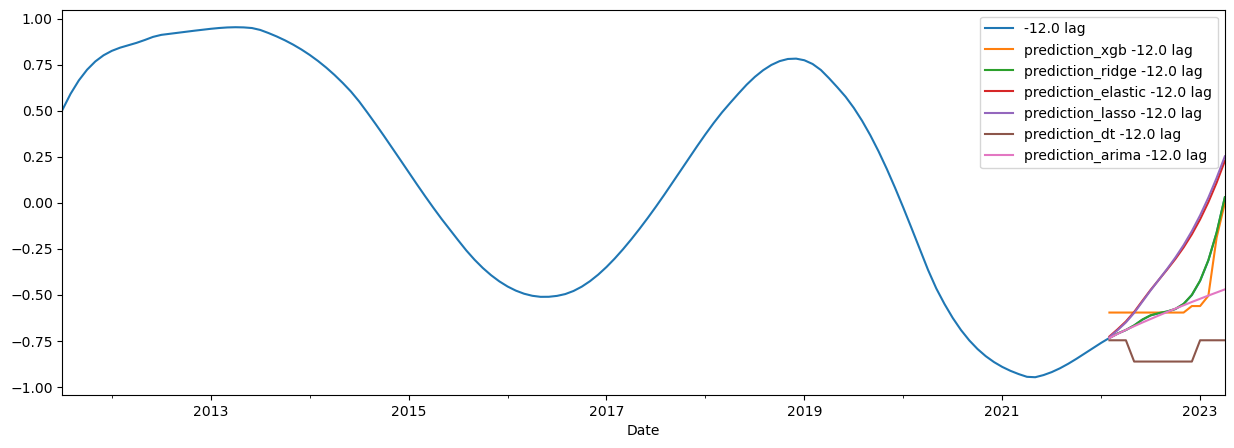

In [104]:
need_idx_y6 = [0,2]
need_idx_y6_pred = [2]

temp1 = pred_xgb_data.iloc[:,need_idx_y6]
temp2 = pred_ridge_data.iloc[:,need_idx_y6_pred]
temp3 = pred_elastic_data.iloc[:,need_idx_y6_pred]
temp4 = pred_lasso_data.iloc[:,need_idx_y6_pred]
temp5 = pred_dt_data.iloc[:,need_idx_y6_pred]
temp6 = pred_arima_data.iloc[:,need_idx_y6_pred]

temp_y6 = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6], axis = 1)
temp_y6.plot(figsize = (15,5))

<Axes: xlabel='Date'>

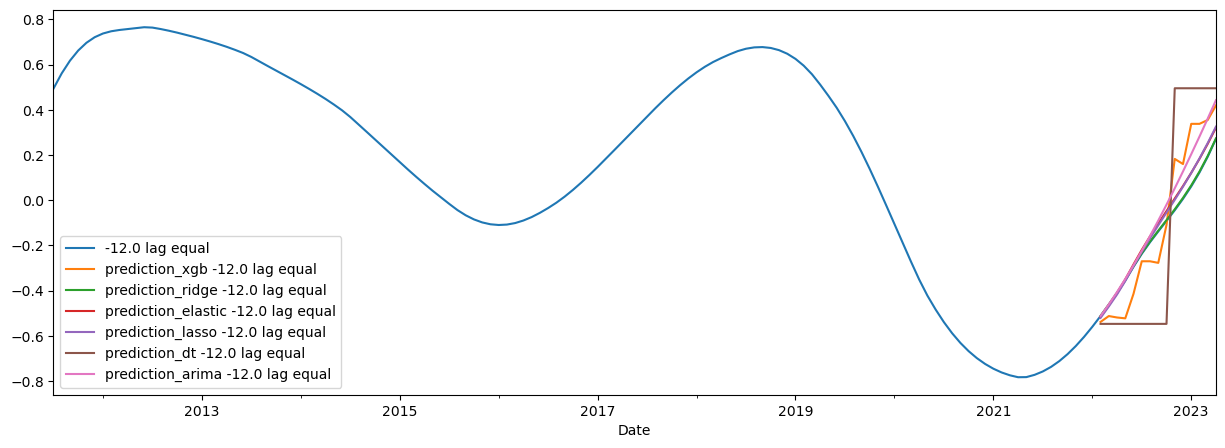

In [105]:
need_idx_y3 = [1,3]
need_idx_y3_pred = [3]

temp7 = pred_xgb_data.iloc[:,need_idx_y3]
temp8 = pred_ridge_data.iloc[:,need_idx_y3_pred]
temp9 = pred_elastic_data.iloc[:,need_idx_y3_pred]
temp10 = pred_lasso_data.iloc[:,need_idx_y3_pred]
temp11 = pred_dt_data.iloc[:,need_idx_y3_pred]
temp12 = pred_arima_data.iloc[:,need_idx_y3_pred]

temp_y3 = pd.concat([temp7, temp8, temp9, temp10, temp11, temp12], axis = 1)
temp_y3.plot(figsize = (15,5))